Dimensionality reduction and cluster analysis of the data

In [2]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats

import anndata
adata = anndata.read_h5ad('../Data/Brain_AllenData.h5ad')
print(adata)

AnnData object with n_obs × n_vars = 978067 × 550
    obs: 'brain_section_label', 'Slice', 'cluster_alias', 'average_correlation_score', 'matrix_label', 'donor_label', 'low_quality_mapping', 'donor_genotype', 'donor_sex', 'x', 'y', 'z', 'node_size', 'neurotransmitter', 'division', 'class', 'subclass', 'supertype', 'cluster'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'normalization', 'parent', 'parent_layer'


In [3]:
#Downsample the cells to a subset of 10,000 random cells

slices = adata.obs['Slice'].unique().tolist()
print(slices)
random_number = np.random.randint(0, len(slices) - 1)
random_slice = slices[random_number]
print(random_slice)
sample = adata[adata.obs['Slice'] == random_slice]
print(sample)

['C57BL6J-638850.01', 'C57BL6J-638850.05', 'C57BL6J-638850.10', 'C57BL6J-638850.14', 'C57BL6J-638850.18', 'C57BL6J-638850.26', 'C57BL6J-638850.30', 'C57BL6J-638850.35', 'C57BL6J-638850.39', 'C57BL6J-638850.44', 'C57BL6J-638850.48', 'C57BL6J-638850.52', 'C57BL6J-638850.57', 'C57BL6J-638850.61', 'C57BL6J-638850.67']
C57BL6J-638850.57
View of AnnData object with n_obs × n_vars = 51765 × 550
    obs: 'brain_section_label', 'Slice', 'cluster_alias', 'average_correlation_score', 'matrix_label', 'donor_label', 'low_quality_mapping', 'donor_genotype', 'donor_sex', 'x', 'y', 'z', 'node_size', 'neurotransmitter', 'division', 'class', 'subclass', 'supertype', 'cluster'
    var: 'gene_symbol', 'transcript_identifier'
    uns: 'normalization', 'parent', 'parent_layer'


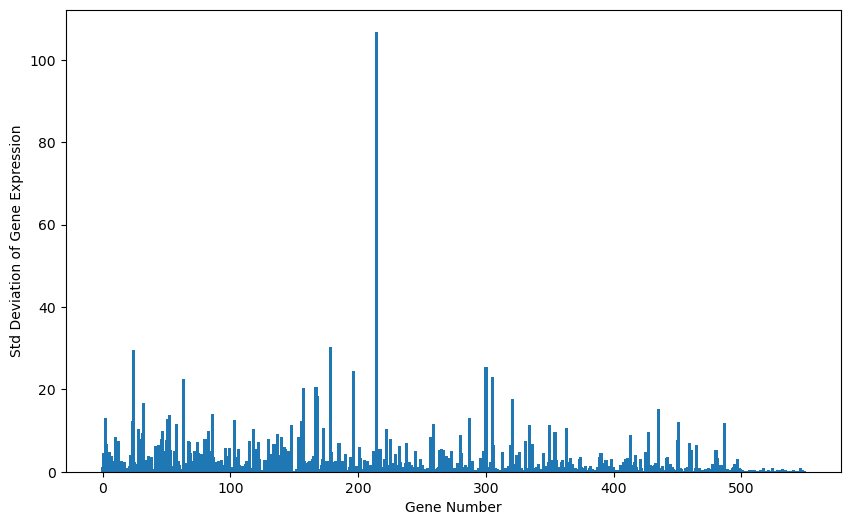

In [9]:
#Look at standard deviations of gene expression levels across the sample

std_deviation = np.std(sample.X.toarray(), axis=0)

x = np.arange(len(std_deviation))  # Create an array of indices
y = std_deviation  # Your array values

plt.figure(figsize=(10, 6))
plt.bar(x, y, width=2.5)
plt.xlabel('Gene Number')
plt.ylabel('Std Deviation of Gene Expression')
plt.show()

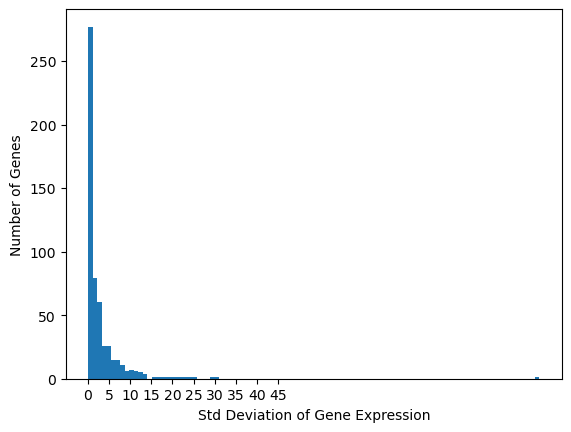

In [10]:
#Plot a histogram of the standard deviations

plt.hist(std_deviation, bins=100)  # Adjust the number of bins as needed
plt.xticks(np.arange(0, 50, 5))
plt.xlabel('Std Deviation of Gene Expression')
plt.ylabel('Number of Genes')
plt.show()

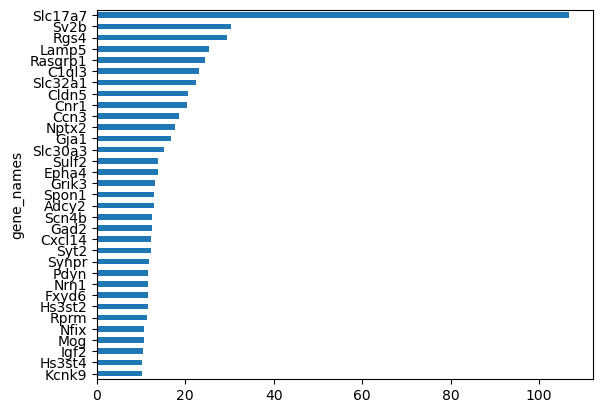

In [14]:
#Make a list of the genes with a significant variance (std dev > 10)

df = pd.DataFrame({
    'gene_names': sample.var['gene_symbol'],
    'std_deviation': std_deviation    
})

df = df.sort_values('std_deviation', ascending=False)

dftop = df[df['std_deviation'] > 10]

fig, ax = plt.subplots()
dftop.plot(kind='barh', x='gene_names', y='std_deviation', ax=ax)
ax.invert_yaxis()
ax.legend().remove()
plt.show()

In [15]:
# Step 1: Identify the indices of the genes in dftop
gene_names_top = dftop['gene_names'].values  # Assuming 'gene_names' is the column with gene names
gene_indices_top = [i for i, gene in enumerate(sample.var['gene_symbol']) if gene in gene_names_top]

# Step 2: Subset the original AnnData object
X_top = sample[:, gene_indices_top].X  # Extract the expression matrix for the selected genes

# Step 3: Create a new AnnData object
top_genes = anndata.AnnData(X=X_top, obs=sample.obs, var=sample.var.iloc[gene_indices_top])

print(top_genes)

AnnData object with n_obs × n_vars = 51765 × 33
    obs: 'brain_section_label', 'Slice', 'cluster_alias', 'average_correlation_score', 'matrix_label', 'donor_label', 'low_quality_mapping', 'donor_genotype', 'donor_sex', 'x', 'y', 'z', 'node_size', 'neurotransmitter', 'division', 'class', 'subclass', 'supertype', 'cluster'
    var: 'gene_symbol', 'transcript_identifier'


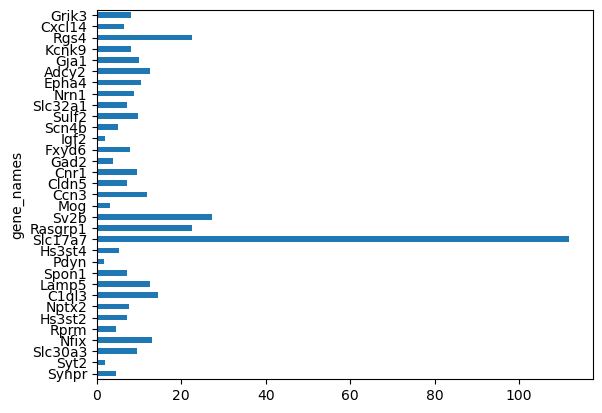

In [17]:
avg_expression = np.mean(top_genes.X.toarray(), axis=0)

df = pd.DataFrame({
    'gene_names': top_genes.var['gene_symbol'],
    'avg_expression': avg_expression    
})

fig, ax = plt.subplots()
df.plot(kind='barh', x='gene_names', y='avg_expression', ax=ax)
ax.invert_yaxis()
ax.legend().remove()
plt.show()

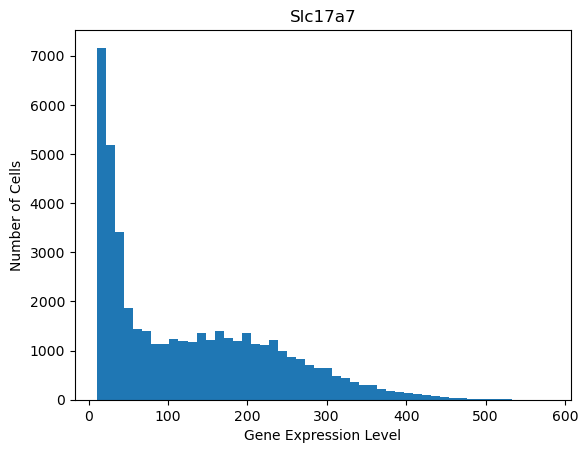

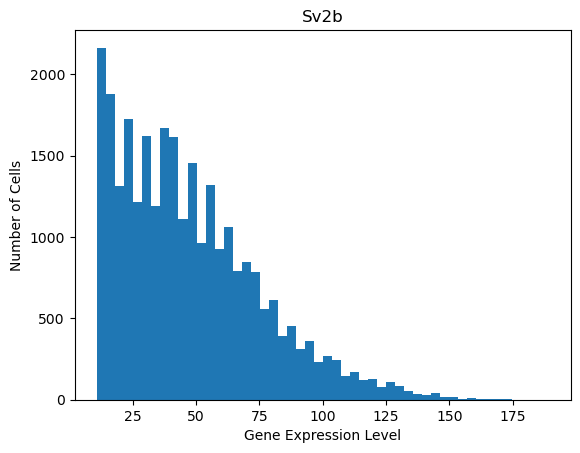

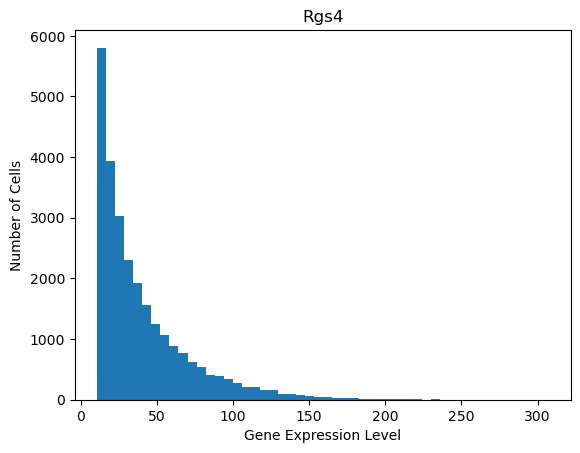

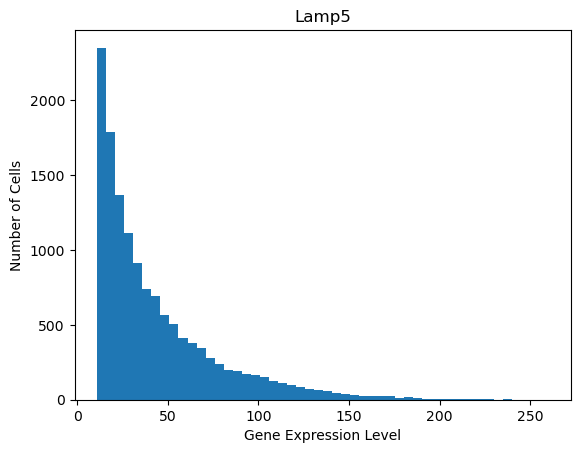

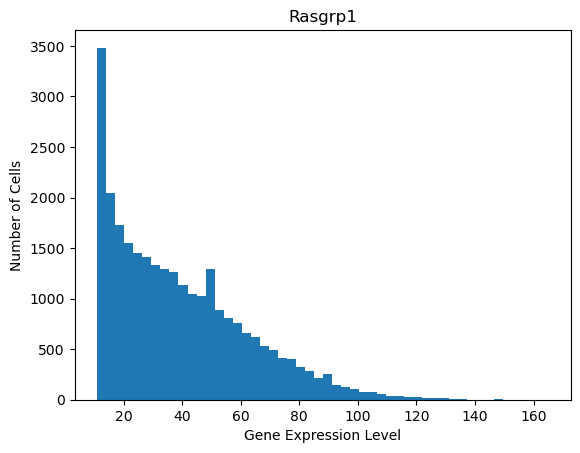

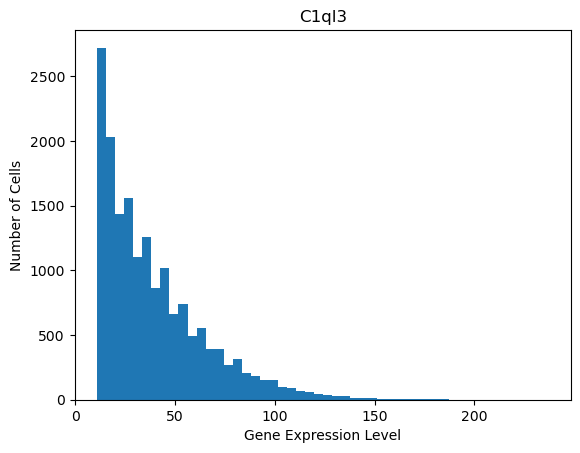

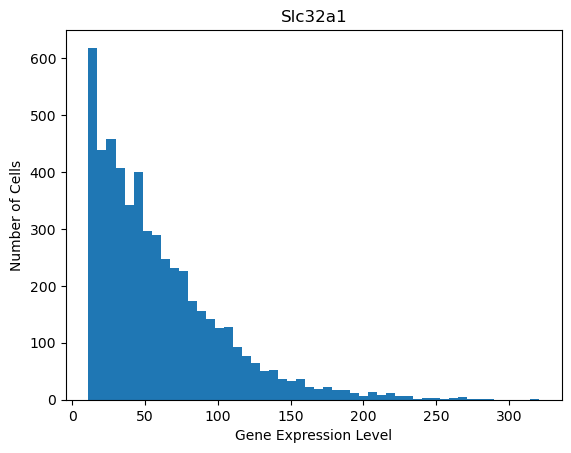

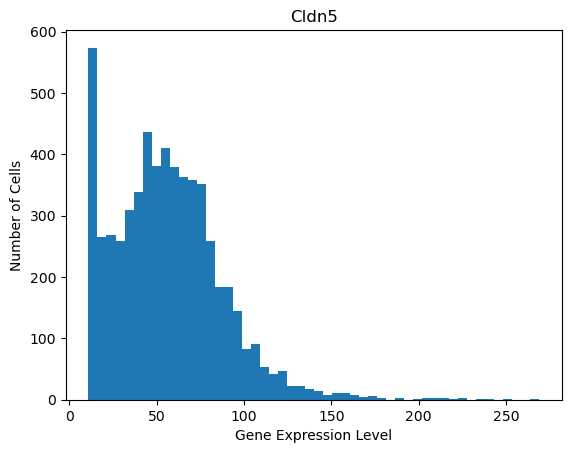

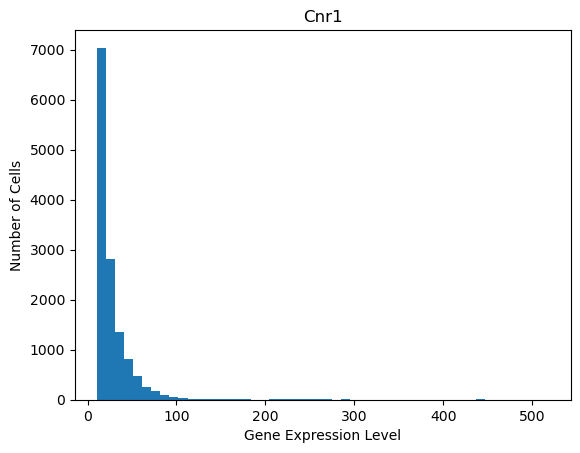

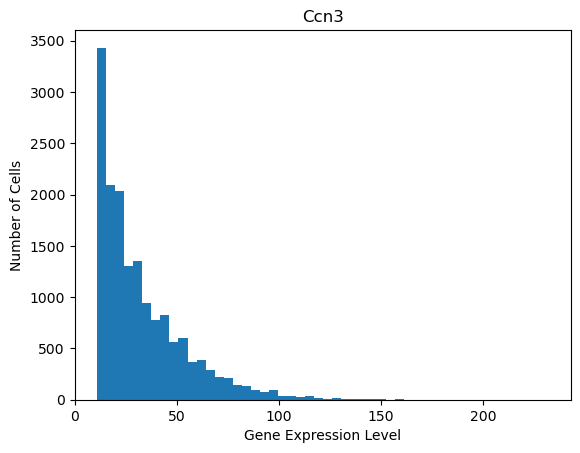

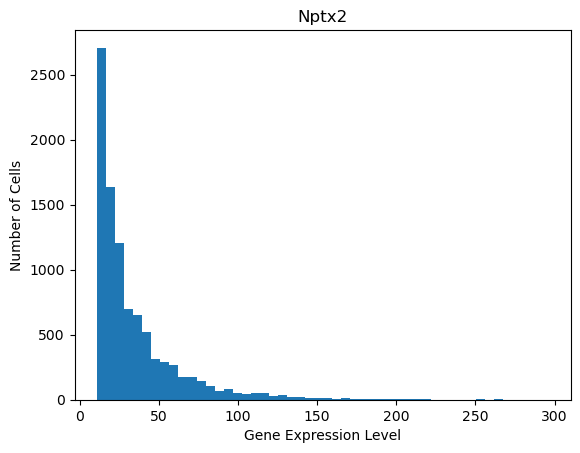

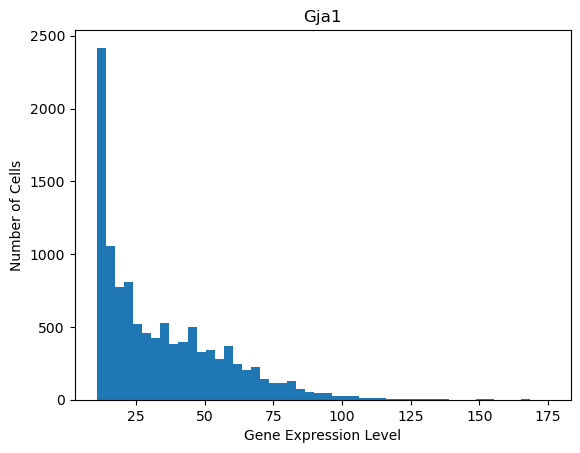

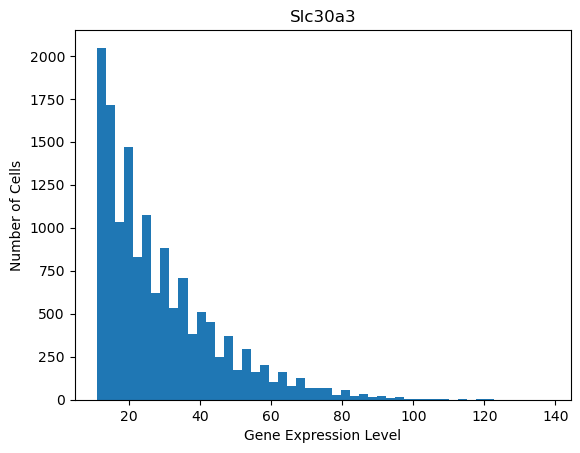

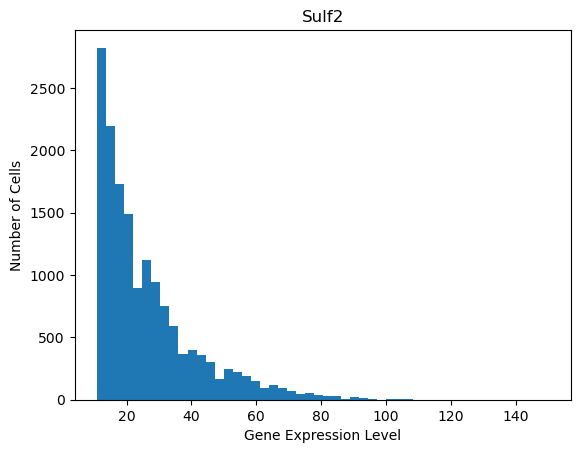

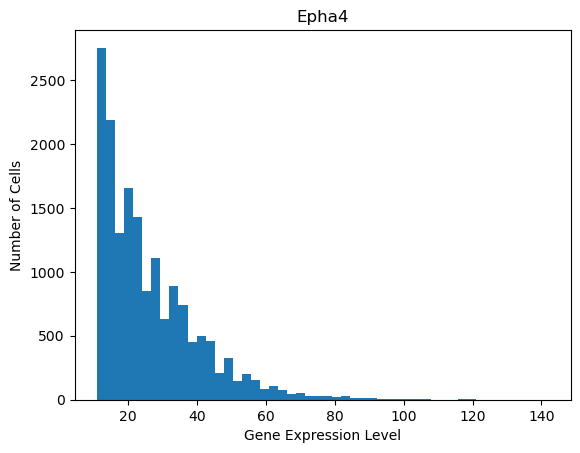

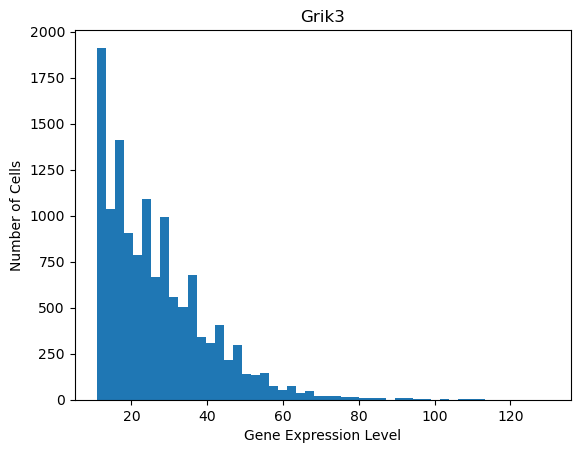

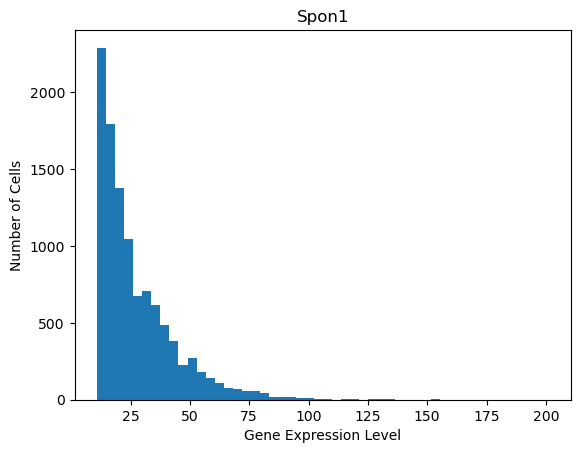

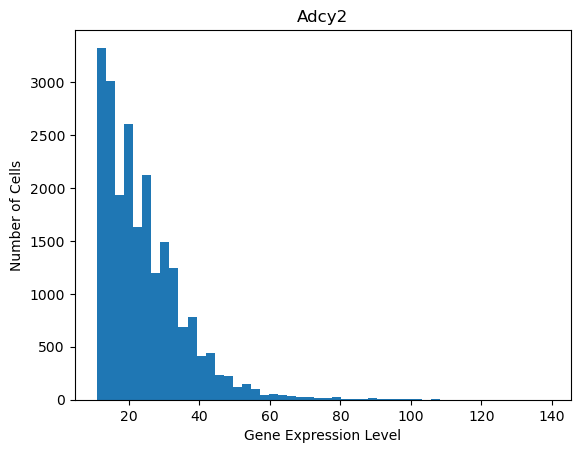

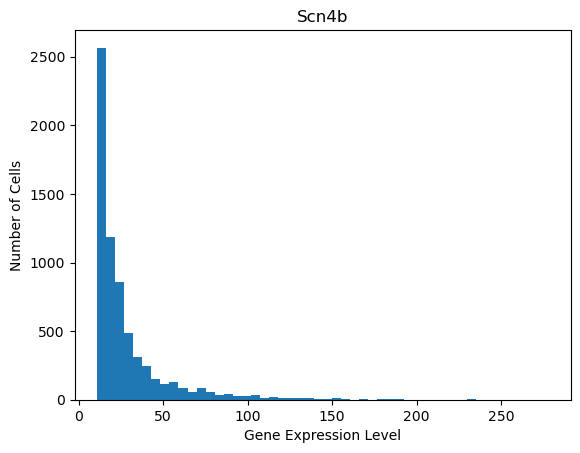

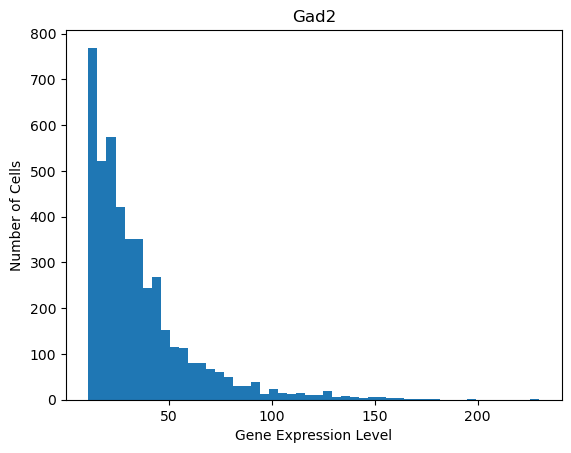

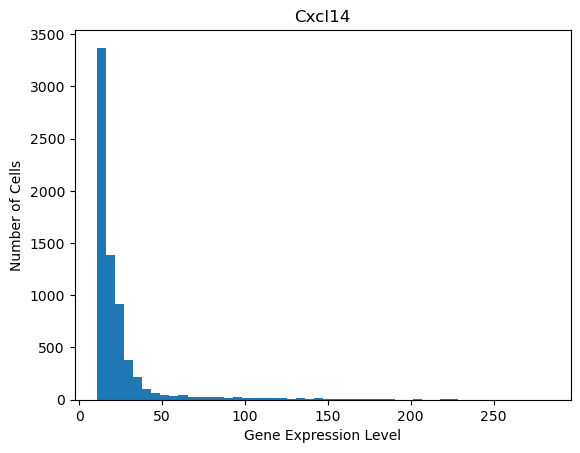

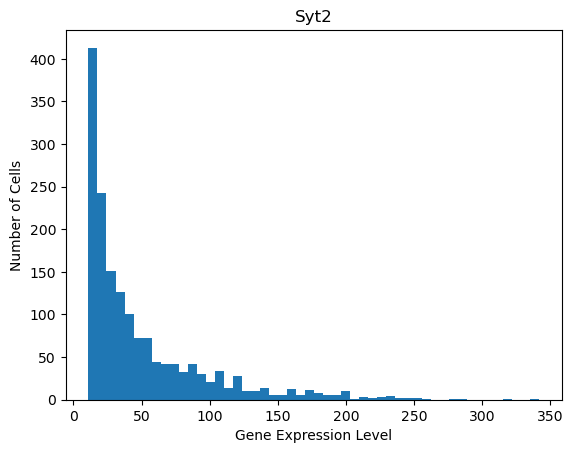

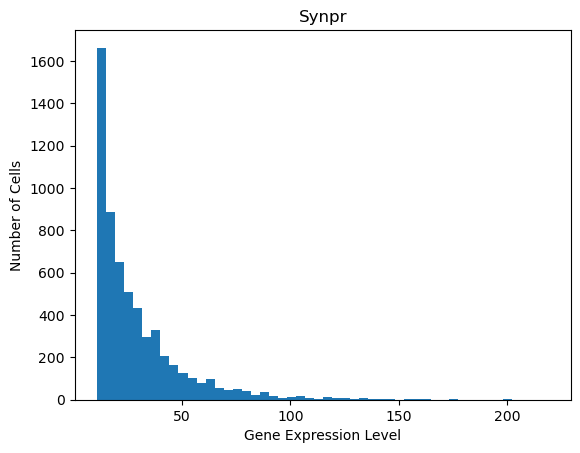

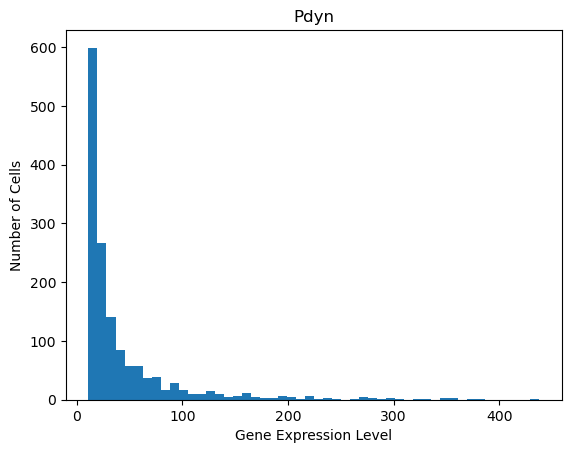

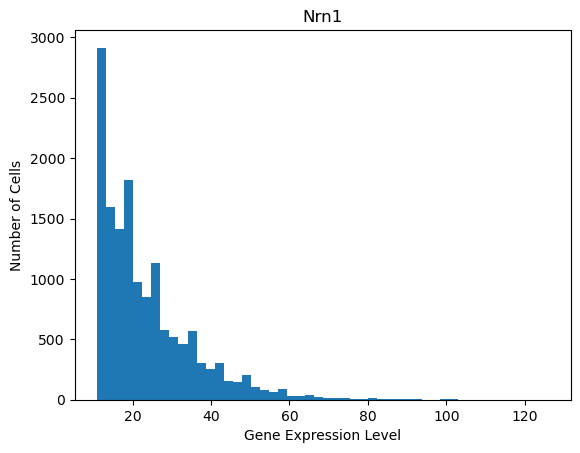

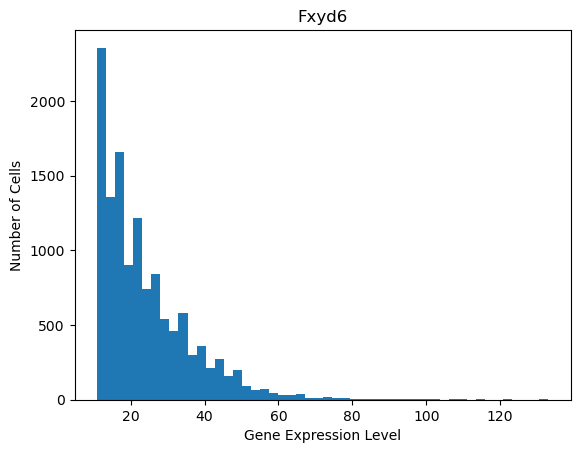

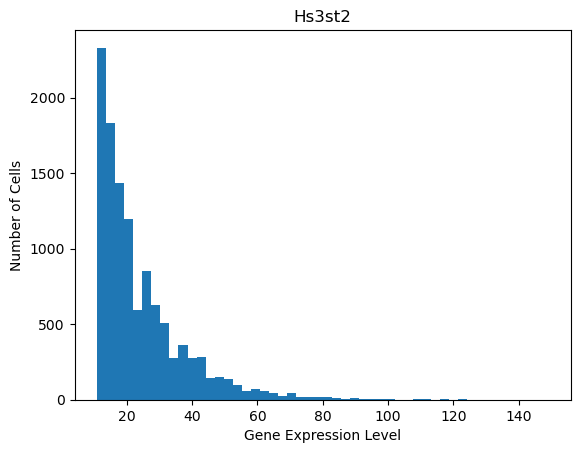

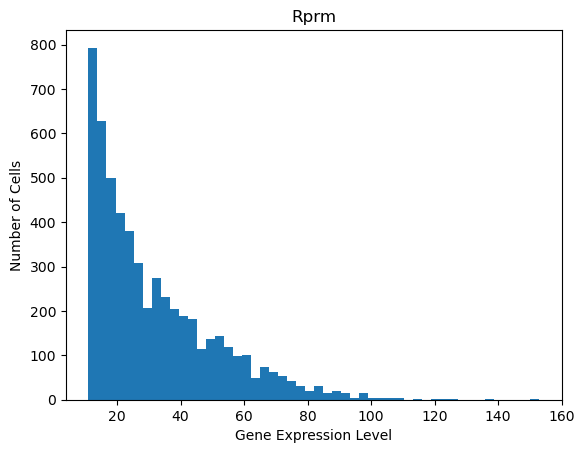

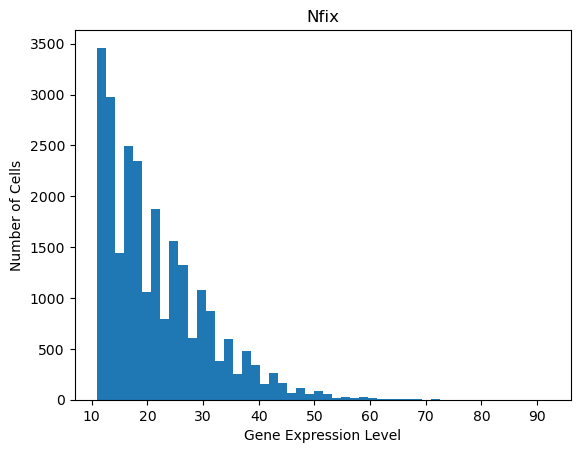

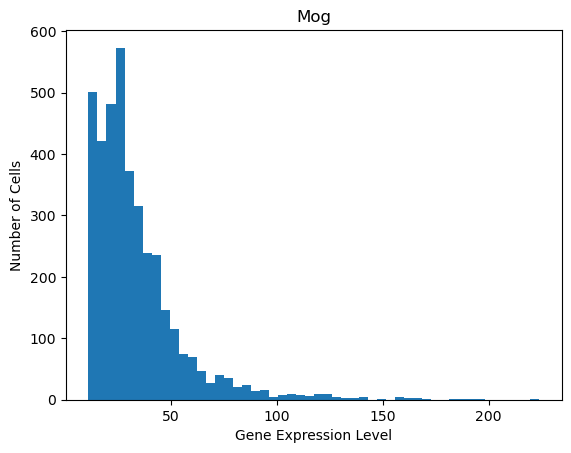

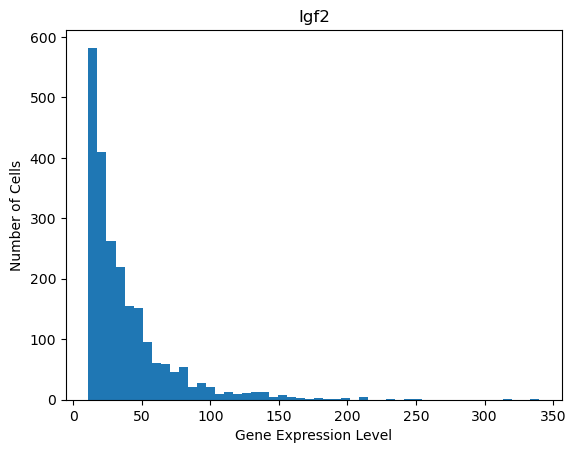

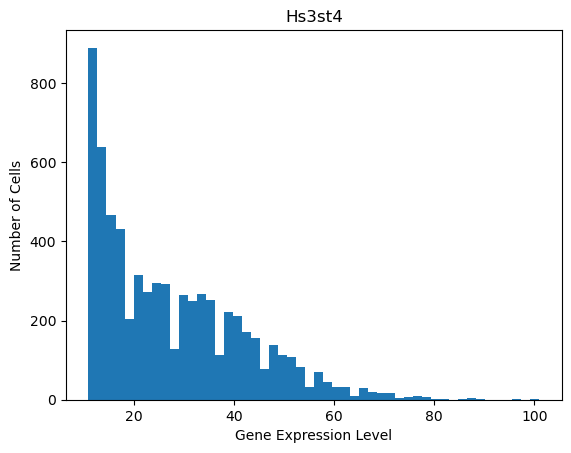

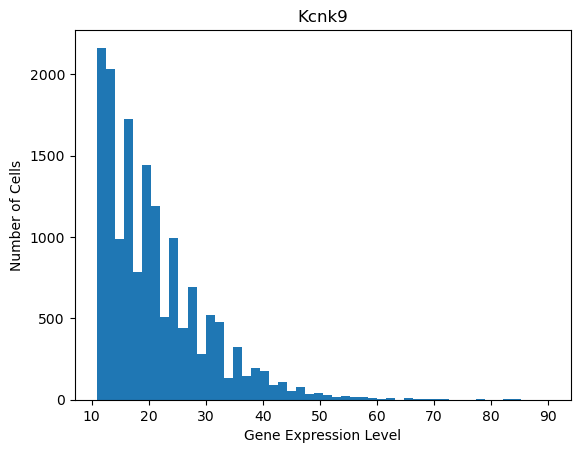

In [24]:
for index, row in dftop.iterrows():
    # Now you can access data in 'row' using column names
    # For example, to get the gene name and its standard deviation:
    gene_name = row['gene_names']
    gene_index = np.where(sample.var['gene_symbol'] == gene_name)[0]
  
      # Step 2: Extract the expression data for this gene
    gene_expression = sample.X[:, gene_index].toarray().flatten()
    gene_expression = gene_expression[gene_expression > 10]

    plt.hist(gene_expression, bins=50)  # Adjust the number of bins as needed
    plt.xlabel('Gene Expression Level')
    plt.ylabel('Number of Cells')
    plt.title(gene_name)
    plt.show()

In [ ]:
# Assuming 'x', 'y', and 'z' are column names in sample.obs for the spatial coordinates
x_coordinates = sample.obs[['x']]
y_coordinates = sample.obs[['y']]

# Calculate the squared distance from (0, 0, 0) for each cell
squared_distances = np.sum(np.square(coordinates), axis=1)

# Take the square root to get the Euclidean distance
distances = np.sqrt(squared_distances)


# Step 1: Identify the column index of the gene

for index, row in dftop.iterrows():
    # Now you can access data in 'row' using column names
    # For example, to get the gene name and its standard deviation:
    gene_name = row['gene_names']
    gene_index = np.where(sample.var['gene_symbol'] == gene_name)[0]
  
      # Step 2: Extract the expression data for this gene
    gene_expression = sample.X[:, gene_index].toarray().flatten()

    plt.scatter(x_coordinates, y_coordinates, c=gene_expression, cmap='viridis', s=1)
    plt.colorbar(label='Gene Expression Level')
    plt.title(gene_name)
    plt.show()